## Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans
from sys import maxsize

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

from mpl_toolkits.basemap import Basemap
import folium
from folium.plugins import HeatMap

from helpers import *

df = pd.read_csv("kc_house_data.csv")

In [2]:
# Global variables we use throughout, which will make more sense as we progress
# Basically, KLUSTERS is the number of K-Clusters we're making within our data
# KFOLDS is the number of k-folds we are creating within each K-Cluster

KLUSTERS=15
KFOLDS = 4

## Data Cleaning

In [3]:
# Filling nulls in the View, Waterfront and Year Renovated columns
for col in ['view', 'waterfront', 'yr_renovated']:
        df[col] = df[col].fillna(0)

In [4]:
# Using sqft_living and sqft_above to fill null sqft_basement rows
df["sqft_basement"] = df.apply(replace_null_basement(df), axis = 1)

In [5]:
# Creating a Posix Date column
df['posix_date'] = df['date'].apply(lambda x: to_posix(x))

In [6]:
# Changing the Date column to be datetime objects
df['date'] = pd.to_datetime(df['date'])

In [7]:
# Changing the values in the Waterfront, View and Year Renovated columns
# to be integers instead of floats
for col in ['waterfront', 'view', 'yr_renovated']:
    df[col] = df[col].apply(lambda x: to_int(x))

In [8]:
# Removing an obvious, problematic outlier with 33 bedrooms
df = df[df['bedrooms']!=33]

## Data Overview

In [9]:
df.head(5)

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...        1180              0   
1      7242     2.0           0     0  ...        2170            400   
2     10000     1.0           0     0  ...         770              0   
3      5000     1.0           0     0  ...        1050            910   
4      8080     1.0           0     0  ...        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15    posix_date  
0        5650  1.413176e+09  
1        7639  1.418105e+09  
2        8062  1.424844e+09  
3        5000  1.418105e+09  
4        7503  1.424239e+09  

[5 rows x 22 columns]

#### Creating a Correlation Heatmap for our variables

In [10]:
# Creating a dataframe for the columns we'll be correlating (excluding ID and date)
df_corr = df.loc[:, "price":"posix_date"]

In [11]:
# Creating the correlation array, making it a dataframe, and renaming columns
map_corr = np.corrcoef(df_corr, rowvar=0)
map_corr = pd.DataFrame(map_corr,
                        columns=['Price', 'Bedrooms', 'Bathrooms', 'Living SqFt', 'Lot SqFt', 'Floors',
                                 'Waterfront', 'View', 'Condition', 'Grade', 'Above-Ground SqFt',
                                 'Basement SqFt', 'Year Built', 'Year Renovated', 'Zipcode', 'Lat', 'Long',
                                 'Neighbor Lv', 'Neighbor Lot', 'Date in Posix'],
                        index=['Price', 'Bedrooms', 'Bathrooms', 'Living SqFt', 'Lot SqFt', 'Floors',
                               'Waterfront', 'View', 'Condition', 'Grade', 'Above-Ground SqFt',
                               'Basement SqFt', 'Year Built', 'Year Renovated', 'Zipcode', 'Lat', 'Long',
                               'Neighbor Lv', 'Neighbor Lot', 'Posix Date'])
map_corr

Price  Bedrooms  Bathrooms  Living SqFt  Lot SqFt  \
Price              1.000000  0.315961   0.525915     0.701929  0.089879   
Bedrooms           0.315961  1.000000   0.527870     0.593178  0.033602   
Bathrooms          0.525915  0.527870   1.000000     0.755755  0.088368   
Living SqFt        0.701929  0.593178   0.755755     1.000000  0.173449   
Lot SqFt           0.089879  0.033602   0.088368     0.173449  1.000000   
Floors             0.256820  0.183707   0.502574     0.353941 -0.004824   
Waterfront         0.264308 -0.002054   0.063628     0.104635  0.021458   
View               0.393502  0.080741   0.186011     0.281710  0.075052   
Condition          0.036031  0.023440  -0.126443    -0.059397 -0.008806   
Grade              0.667964  0.366174   0.665834     0.762776  0.114726   
Above-Ground SqFt  0.605392  0.492543   0.686664     0.876448  0.184134   
Basement SqFt      0.323794  0.309261   0.283459     0.435152  0.015424   
Year Built         0.053965  0.160736   0.507166     0.318140  0.052939   
Year Renovated     0.117858  0.018626   0.047173     0.051056  0.004977   
Zipcode           -0.053409 -0.158588  -0.204778    -0.199793 -0.129582   
Lat                0.306687 -0.011595   0.024301     0.052178 -0.085507   
Long               0.022047  0.136561   0.224889     0.241200  0.230222   
Neighbor Lv        0.585267  0.404532   0.569878     0.756400  0.144756   
Neighbor Lot       0.082849  0.031892   0.088297     0.184337  0.718203   
Posix Date        -0.003988 -0.015235  -0.034263    -0.034303  0.006326   

                     Floors  Waterfront      View  Condition     Grade  \
Price              0.256820    0.264308  0.393502   0.036031  0.667964   
Bedrooms           0.183707   -0.002054  0.080741   0.023440  0.366174   
Bathrooms          0.502574    0.063628  0.186011  -0.126443  0.665834   
Living SqFt        0.353941    0.104635  0.281710  -0.059397  0.762776   
Lot SqFt          -0.004824    0.021458  0.075052  -0.008806  0.114726   
Floors             1.000000    0.020794  0.028401  -0.264013  0.458783   
Waterfront         0.020794    1.000000  0.380543   0.016659  0.082817   
View               0.028401    0.380543  1.000000   0.045663  0.249077   
Condition         -0.264013    0.016659  0.045663   1.000000 -0.146854   
Grade              0.458783    0.082817  0.249077  -0.146854  1.000000   
Above-Ground SqFt  0.523970    0.071776  0.166007  -0.158826  0.756069   
Basement SqFt     -0.245694    0.082803  0.273858   0.173801  0.168240   
Year Built         0.489175   -0.024491 -0.054464  -0.361555  0.447854   
Year Renovated     0.003785    0.073938  0.090337  -0.055795  0.015618   
Zipcode           -0.059522    0.028925  0.085066   0.002835 -0.185761   
Lat                0.049280   -0.012154  0.006334  -0.015209  0.113602   
Long               0.125912   -0.037632 -0.077715  -0.105800  0.200324   
Neighbor Lv        0.280072    0.083822  0.278921  -0.092979  0.713863   
Neighbor Lot      -0.010734    0.030657  0.073079  -0.003093  0.120974   
Posix Date        -0.022382    0.000359 -0.001646  -0.050765 -0.039804   

                   Above-Ground SqFt  Basement SqFt  Year Built  \
Price                       0.605392       0.323794    0.053965   
Bedrooms                    0.492543       0.309261    0.160736   
Bathrooms                   0.686664       0.283459    0.507166   
Living SqFt                 0.876448       0.435152    0.318140   
Lot SqFt                    0.184134       0.015424    0.052939   
Floors                      0.523970      -0.245694    0.489175   
Waterfront                  0.071776       0.082803   -0.024491   
View                        0.166007       0.273858   -0.054464   
Condition                  -0.158826       0.173801   -0.361555   
Grade                       0.756069       0.168240    0.447854   
Above-Ground SqFt           1.000000      -0.052130    0.424017   
Basement SqFt              -0.052130       1.000000   -0.133043   
Year Built          

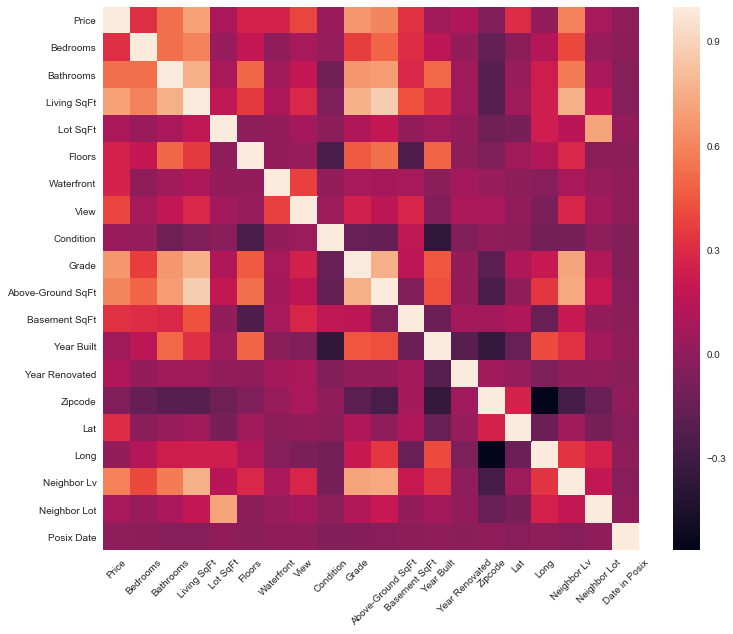

In [12]:
# Creating and displaying the correlation heatmap 
plt.figure(figsize=(12,10))
ax = sns.heatmap(data = map_corr)
plt.xticks(rotation=45)
plt.show()

#### Finding the variables that are the strongest predictors for price

In [13]:
highest_corr_models = pd.DataFrame(columns=["param","greatest_rsquared","model"])
for col in df.columns:
    if col == "price":
        continue
    if col == "date":
        continue
    modeling_params = "price~" + col
    models=[]
    tt_splits = k_fold_tt_splits(KFOLDS, df)
    for data in tt_splits:
        model = ols(formula= modeling_params, data=data[0]).fit()
        models.append(model)
    most_corr_model = sorted(models, key=lambda x: x.rsquared,reverse=True)[0]
    highest_corr_models=highest_corr_models.append({
        "param":col,
        "greatest_rsquared":most_corr_model.rsquared,
        "model" : most_corr_model,
    },ignore_index=True)

In [45]:
def plot_rsquared(row):
    fig1 = plt.figure(figsize=(15,8))
    fig1 = sm.graphics.plot_regress_exog(row["model"], row["param"], fig=fig1)
    plt.show()
    print("R-Squared:", row["model"].rsquared)
    print("-"*115)

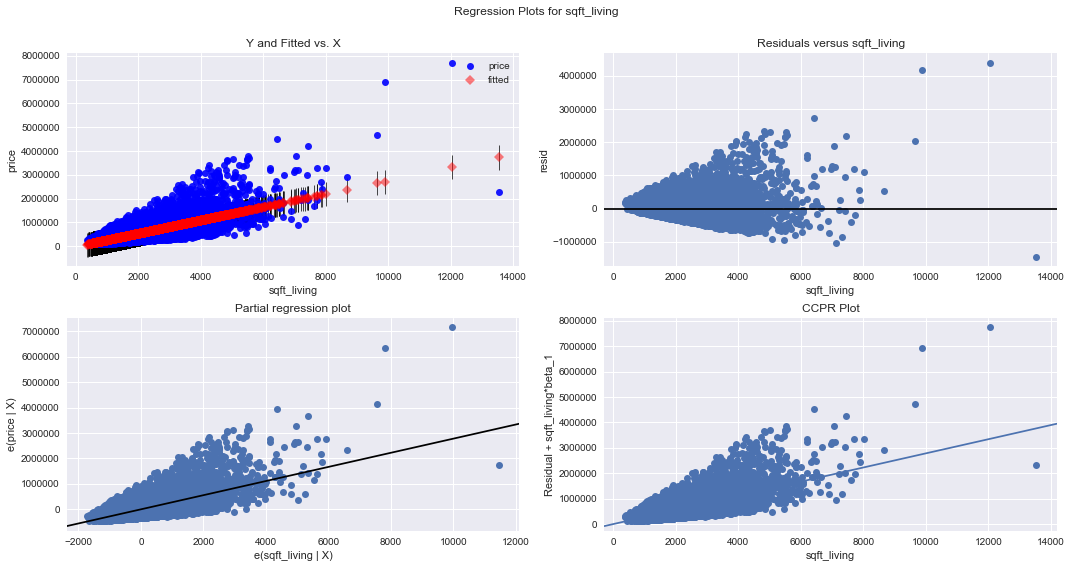

R-Squared: 0.495831585571496
-------------------------------------------------------------------------------------------------------------------


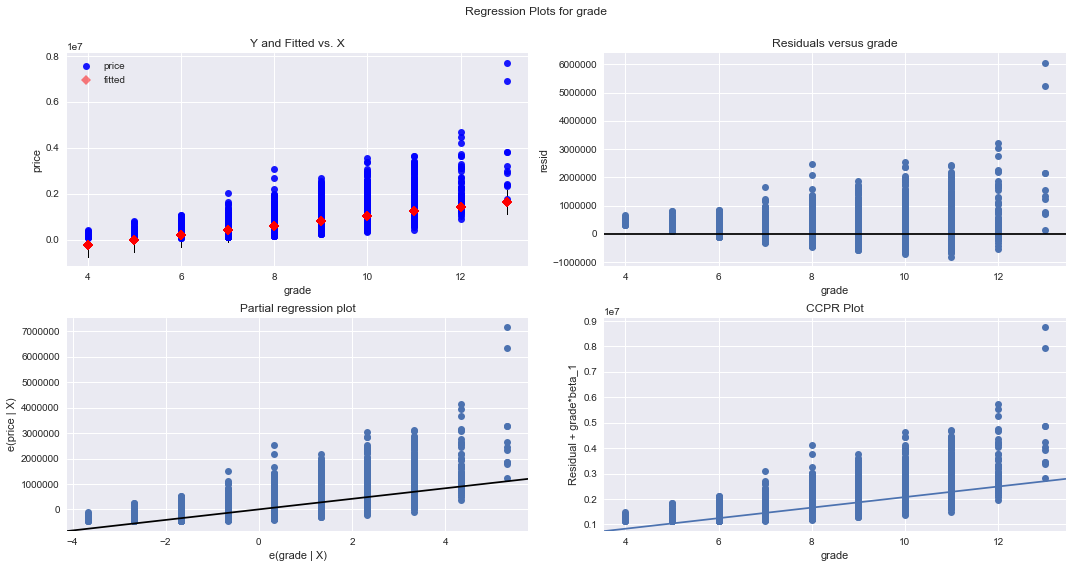

R-Squared: 0.45475740505467344
-------------------------------------------------------------------------------------------------------------------


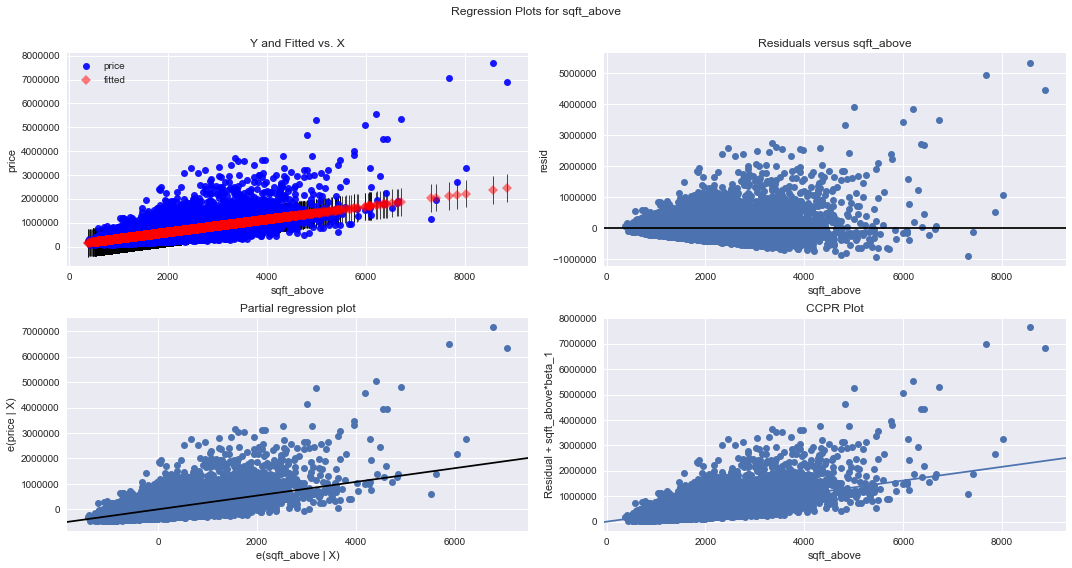

R-Squared: 0.3692640867393303
-------------------------------------------------------------------------------------------------------------------


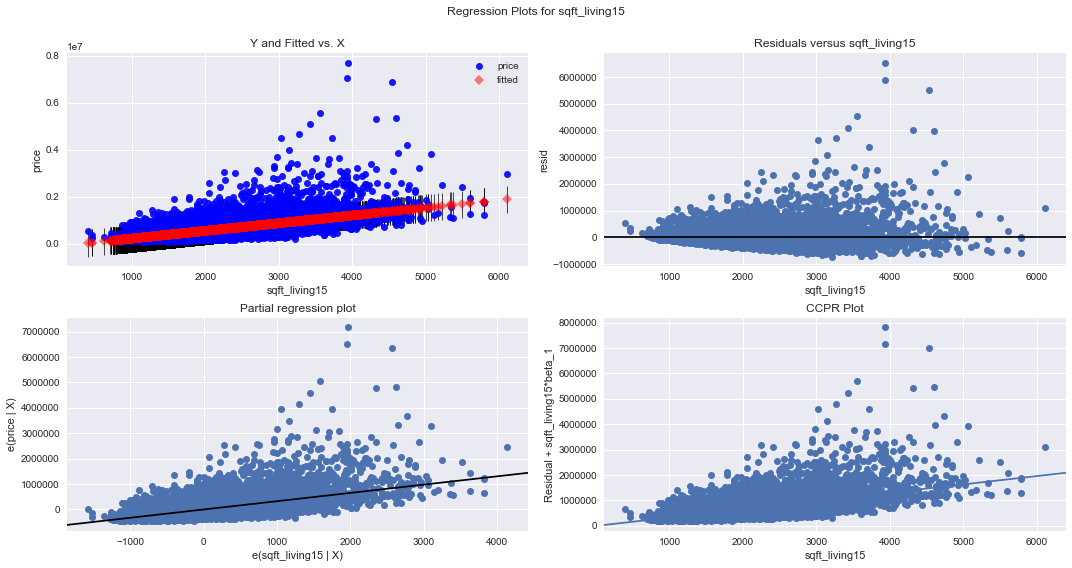

R-Squared: 0.36039479057855206
-------------------------------------------------------------------------------------------------------------------


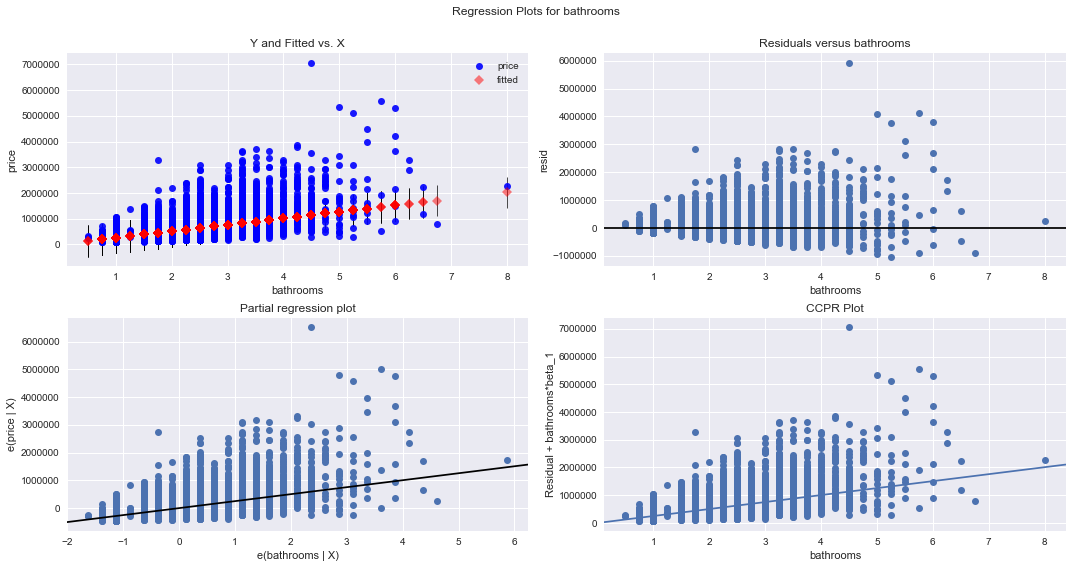

R-Squared: 0.27901025357877585
-------------------------------------------------------------------------------------------------------------------


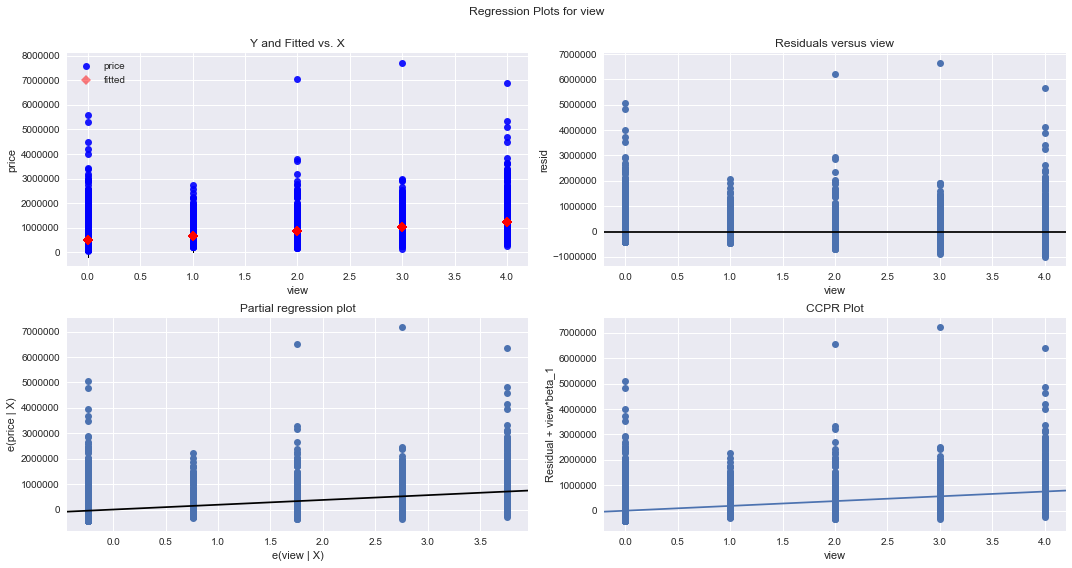

R-Squared: 0.16037201388767497
-------------------------------------------------------------------------------------------------------------------


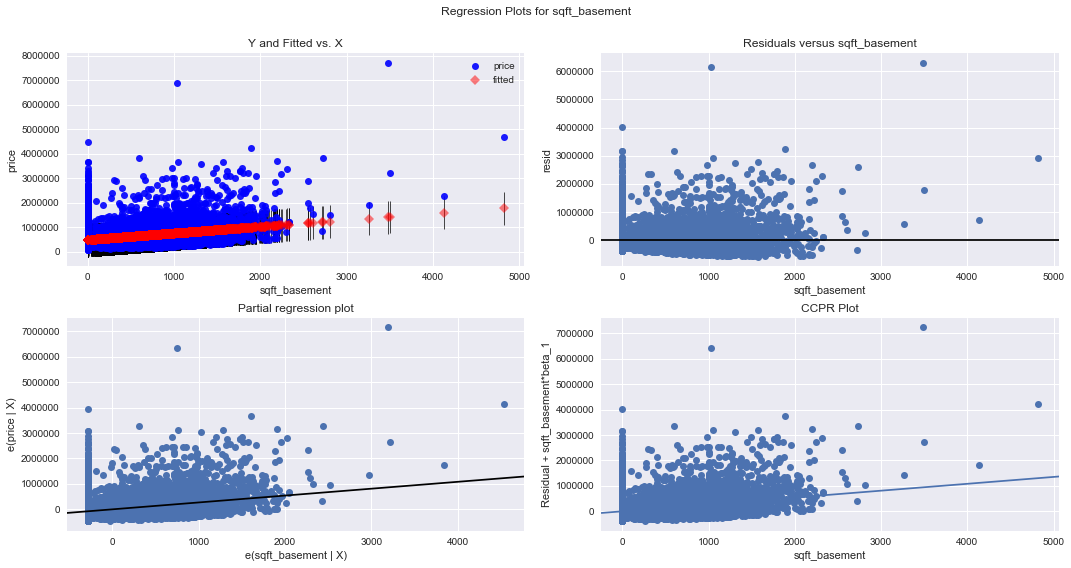

R-Squared: 0.10784496608197636
-------------------------------------------------------------------------------------------------------------------


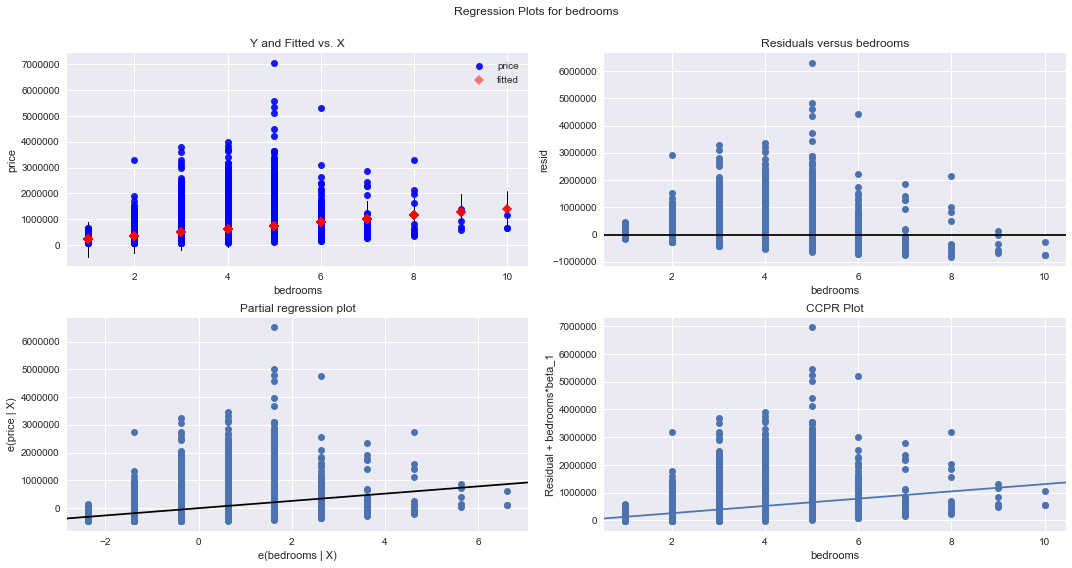

R-Squared: 0.1036952409364843
-------------------------------------------------------------------------------------------------------------------


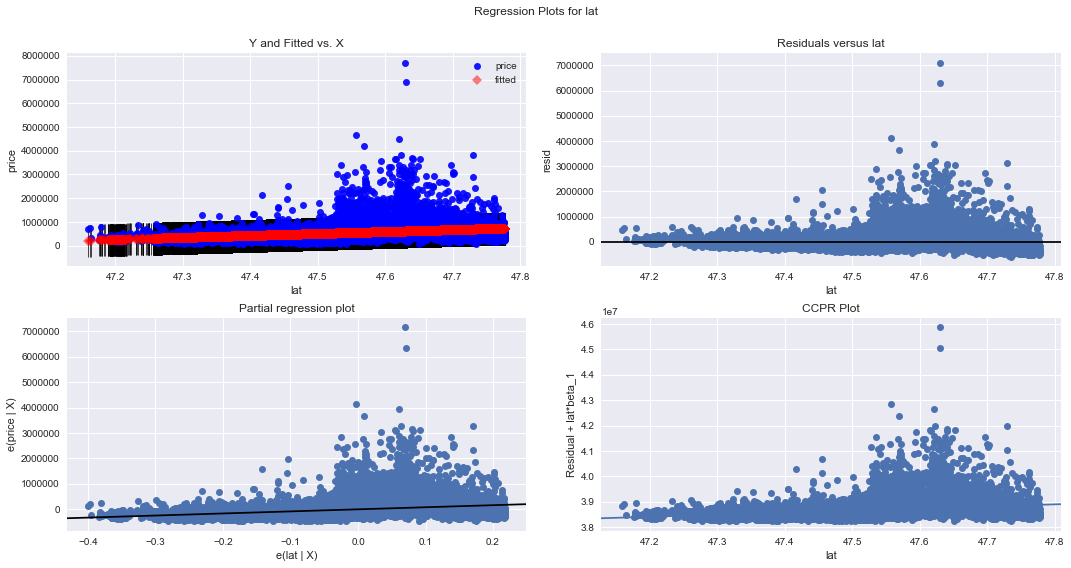

R-Squared: 0.09672175890654788
-------------------------------------------------------------------------------------------------------------------


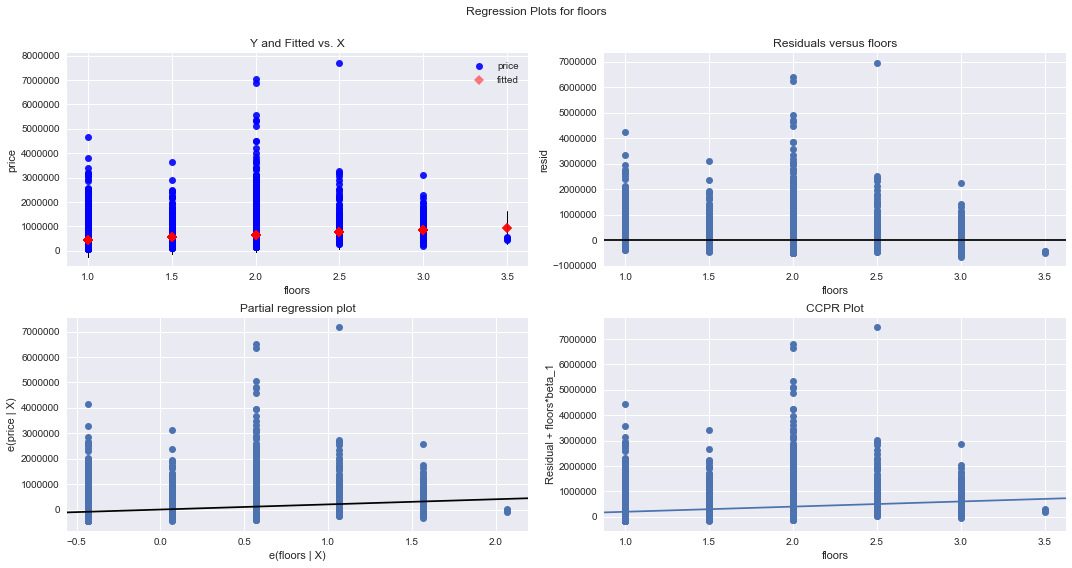

R-Squared: 0.07927066610165778
-------------------------------------------------------------------------------------------------------------------


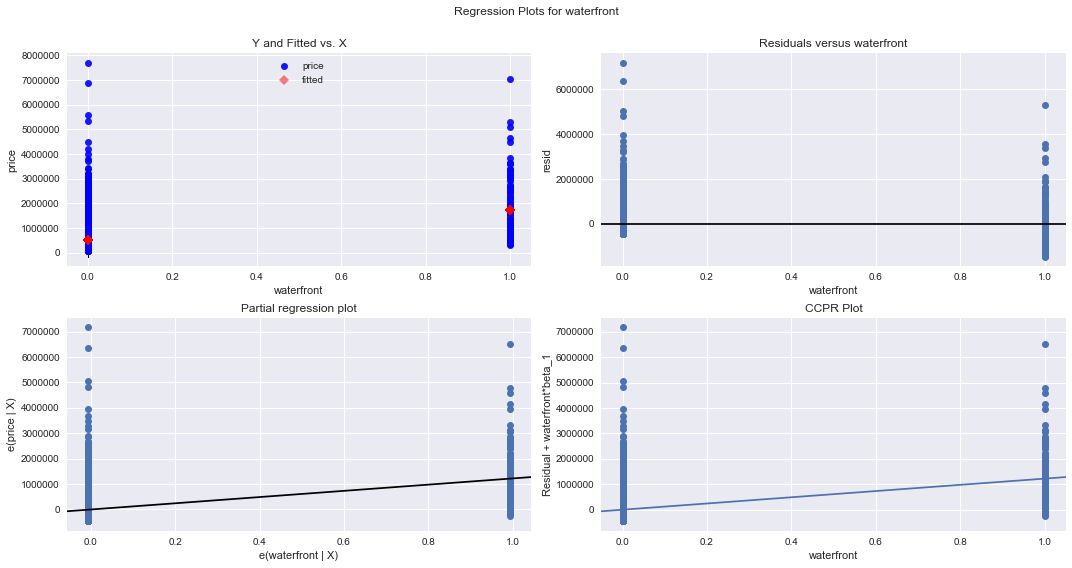

R-Squared: 0.07623990063300556
-------------------------------------------------------------------------------------------------------------------


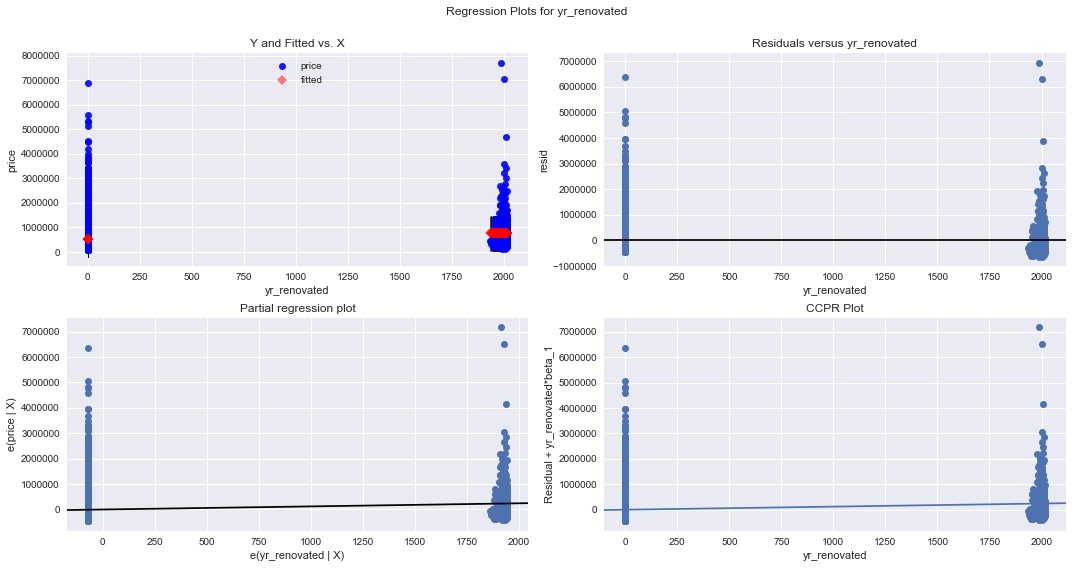

R-Squared: 0.01542698716385038
-------------------------------------------------------------------------------------------------------------------


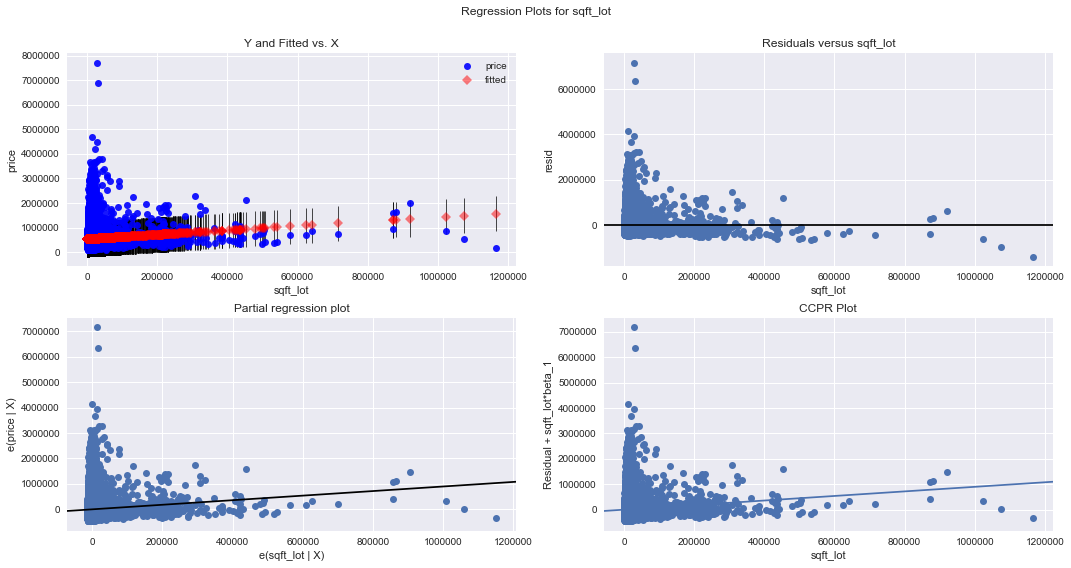

R-Squared: 0.009589339332994995
-------------------------------------------------------------------------------------------------------------------


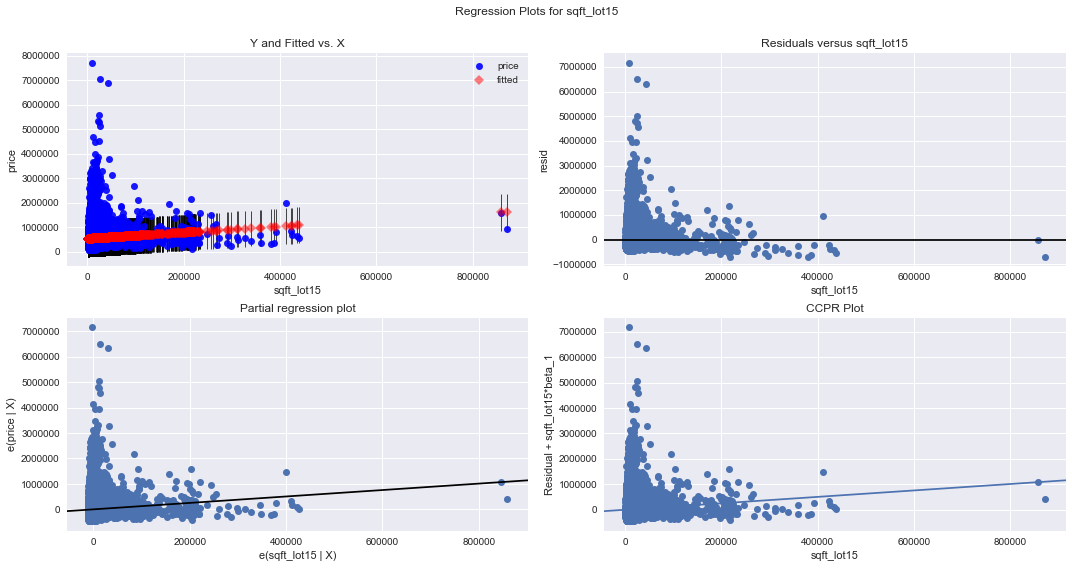

R-Squared: 0.008163823796558445
-------------------------------------------------------------------------------------------------------------------


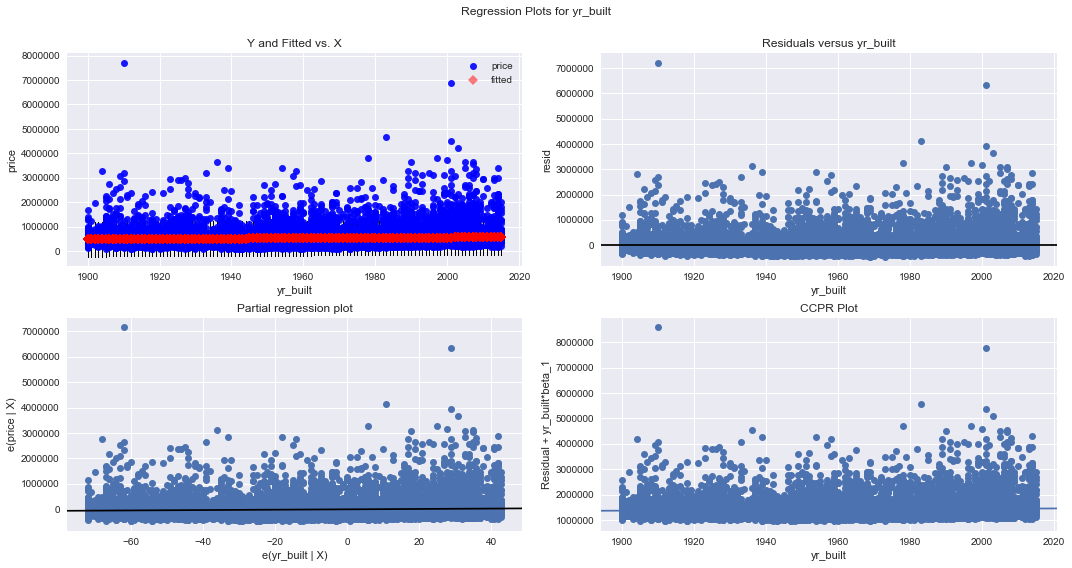

R-Squared: 0.003451725836639552
-------------------------------------------------------------------------------------------------------------------


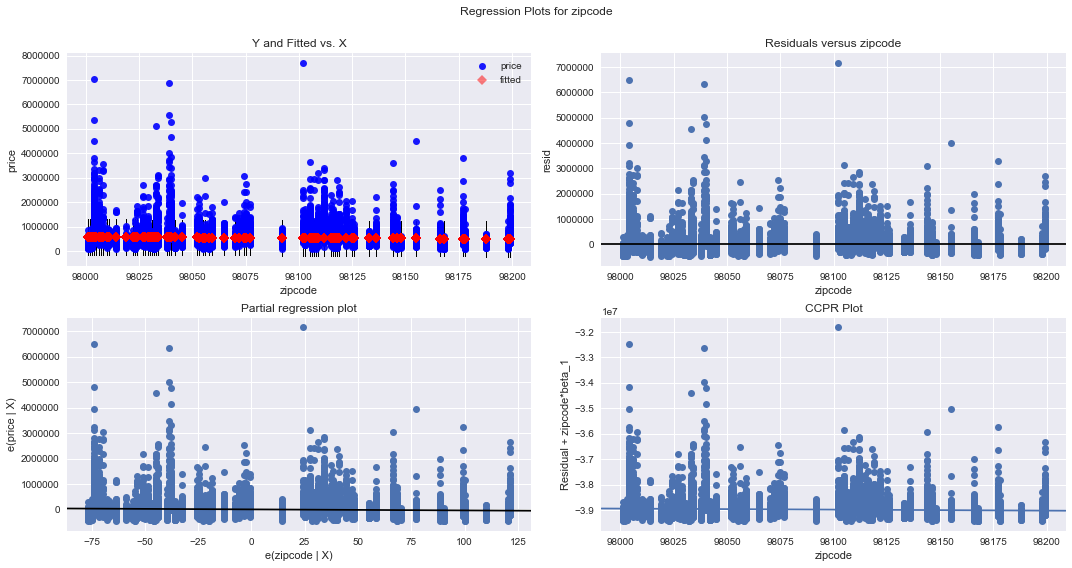

R-Squared: 0.003257795977049005
-------------------------------------------------------------------------------------------------------------------


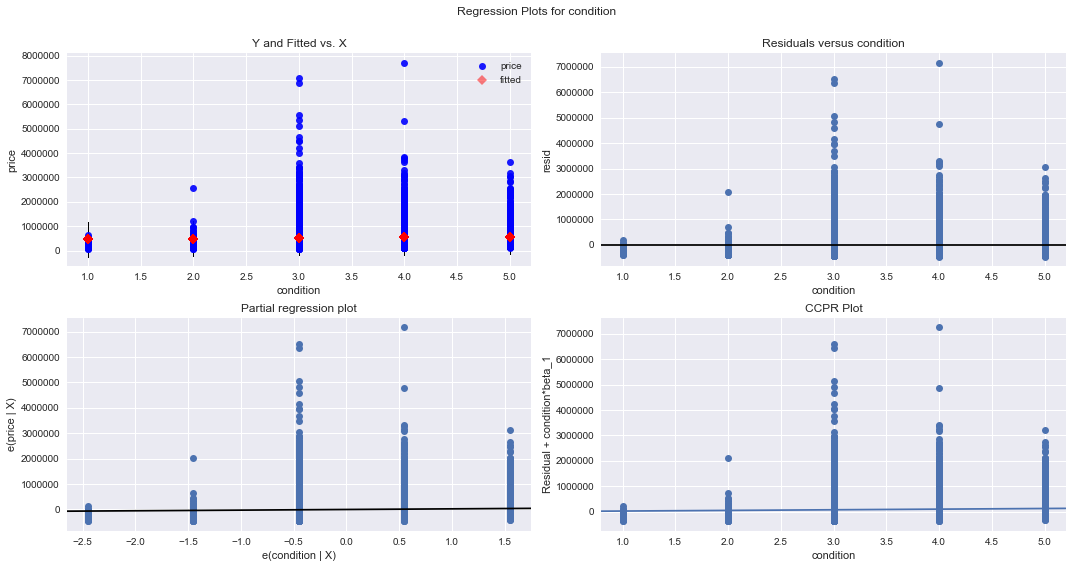

R-Squared: 0.002072432234712762
-------------------------------------------------------------------------------------------------------------------


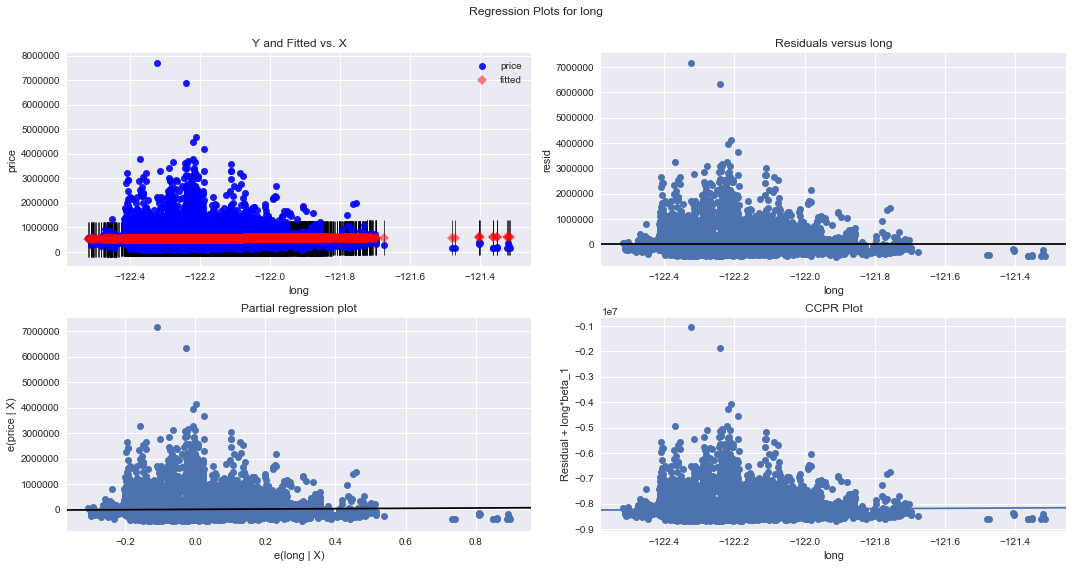

R-Squared: 0.0006813183286100699
-------------------------------------------------------------------------------------------------------------------


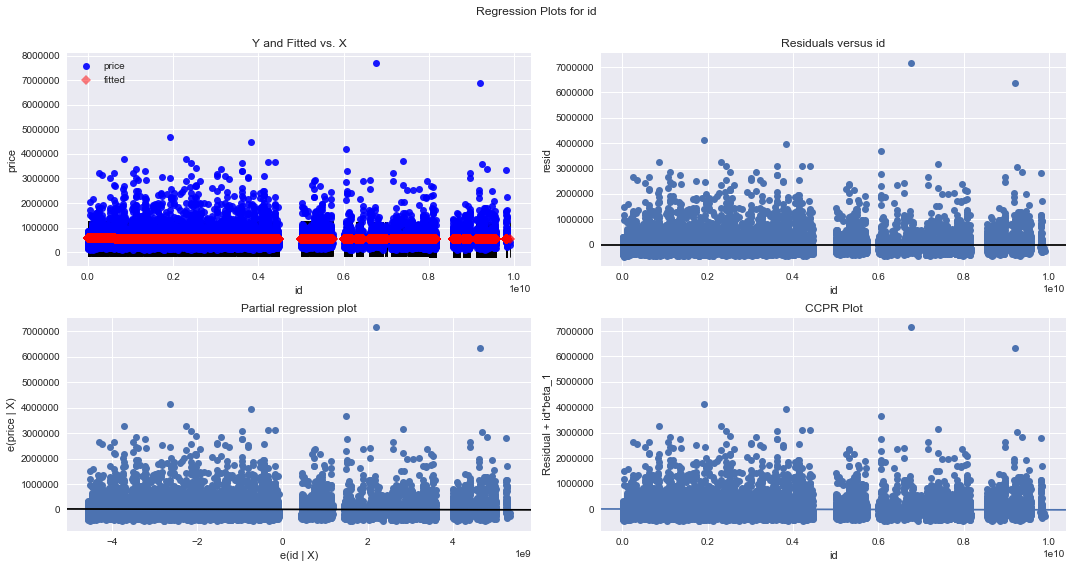

R-Squared: 0.0006434425121466525
-------------------------------------------------------------------------------------------------------------------


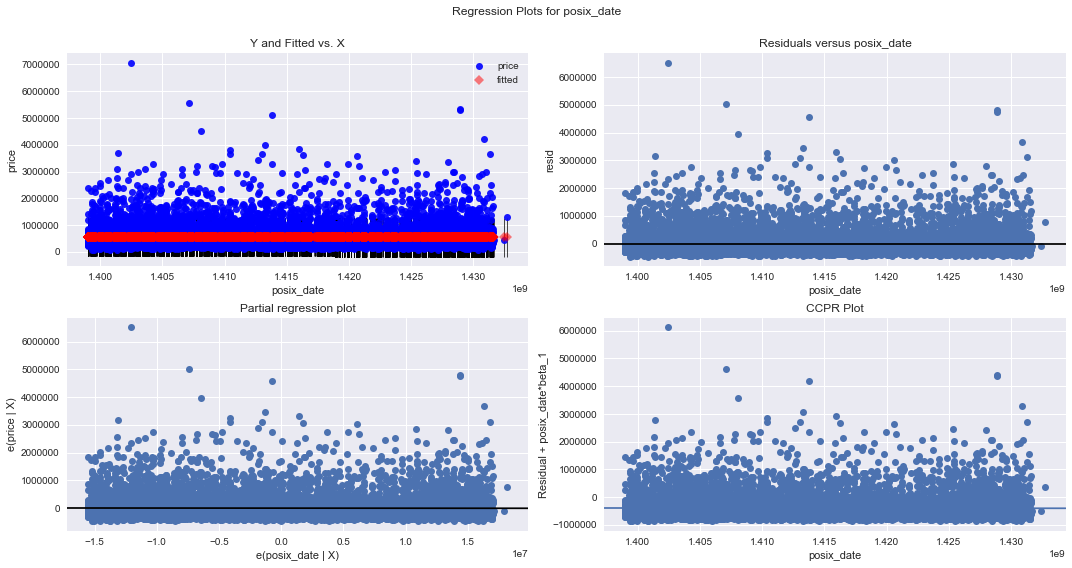

R-Squared: 5.540134338333225e-05
-------------------------------------------------------------------------------------------------------------------


3     None
9     None
10    None
17    None
2     None
7     None
11    None
1     None
15    None
5     None
6     None
13    None
4     None
18    None
12    None
14    None
8     None
16    None
0     None
19    None
dtype: object

In [46]:
highest_corr_models.sort_values(by=["greatest_rsquared"], inplace=True, ascending=False)
highest_corr_models.apply(lambda x: plot_rsquared(x), axis=1)

## Question 1: Can we see a difference between where the most and least expensive homes are located?

#### Creating a map displaying the 1000 most expensive homes

In [16]:
# Creating the dataframe for the 1000 most expensive homes
df.sort_values("price", ascending=False)
most_exp_df = df.filter(['price','lat','long', 'zipcode'], axis=1)
most_exp_df = most_exp_df.nlargest(1000, "price")

In [17]:
# Creating the map, focused on the average of our lat/long values in our data
m1 = folium.Map(location=[47.56009, -122.21398],
                zoom_start=9.45, prefer_canvas=True)

# Changing the background map type
folium.TileLayer("cartodbpositron").add_to(m1)

# Marking each home as a point
for index, row in most_exp_df.iterrows():

    # Adding popup text, so clicking each point shows details
    popup_text = "price: {}<br> latitude: {}<br> longitude: {}"
    popup_text = popup_text.format(row["price"],
                                   row["lat"],
                                   row["long"])
    
    # Changing the color based on buckets of cost
    if row["price"] < 2000000:
        color = "#85CB33" #green
    elif row["price"] >= 2000000 and row["price"] < 3000000:
        color = "#F9B700" #yellow
    else:
        color = "#E01A4F" #hot pink

    # Actually adding the markers to the map
    folium.CircleMarker([row['lat'], row['long']],
                        radius=(row["price"]/1000000),
                        color=color,
                        fill=True,
                        popup=popup_text).add_to(m1)

m1
Can we see a difference between where the most and least expensive homes are located?

#### Creating a map displaying the 1000 least expensive homes

In [18]:
# Creating the dataframe for the 1000 least expensive homes
least_exp_df = df.filter(['price','lat','long', 'zipcode'], axis=1)
least_exp_df = least_exp_df.nsmallest(1000, "price")

In [19]:
# Creating the map, focused on the average of our lat/long values in our data
m2 = folium.Map(location=[47.56009, -122.21398],
                zoom_start=9.45, prefer_canvas=True)

# Changing the background map type
folium.TileLayer("cartodbpositron").add_to(m2)

# Marking each home as a point
for index, row in least_exp_df.iterrows():

    # Adding popup text, so clicking each point shows details
    popup_text = "price: {}<br> latitude: {}<br> longitude: {}"
    popup_text = popup_text.format(row["price"],
                                   row["lat"],
                                   row["long"])

    # Changing the color based on buckets of cost
    if row["price"] < 100000:
        color = "#39AECC"  # blue
    elif row["price"] >= 100000 and row["price"] < 200000:
        color = "#F9C62C"  # yellow
    else:
        color = "#FF5A30"  # orange
    
    # Actually adding the markers to the map
    folium.CircleMarker([row['lat'], row['long']],
                        radius=(row["price"]/100000),
                        color=color,
                        fill=True,
                        popup=popup_text).add_to(m2)

m2

## Question 2: For the homes where we have data on the last year renovated, does year renovated have a similar impact as age?

In [20]:
# Creating a new dataframe with only these four columns
q2_df = df.filter(["date", "price", "yr_built", "yr_renovated"])

In [21]:
# New column for the year a home was sold, derived from the Date column
q2_df['yr_sold'] = pd.DatetimeIndex(q2_df['date']).year

In [22]:
# New column for age of homes
q2_df['home_age'] = q2_df["yr_sold"] - q2_df["yr_built"]

In [23]:
# Creating a dataframe with all homes that have information on when they were renovated
with_reno_df = q2_df.where(q2_df["yr_renovated"] > 0).dropna()

# Creating a new column just for this 'with renovations' dataframe, 
# showing the number of years since the home was renovated
with_reno_df['since_reno'] = with_reno_df["yr_sold"] - q2_df["yr_renovated"]

# Excluding those renovated after they were sold
with_reno_df = with_reno_df.where(with_reno_df["since_reno"] > 0)

In [24]:
# Creating a dataframe with all homes that do not have information on when they were renovated
without_reno_df = q2_df.where(q2_df["yr_renovated"] == 0).dropna()

# Excluding those built after they were sold
without_reno_df = without_reno_df.where(without_reno_df["home_age"] > 0)

#### Question 2 Data Overview

In [25]:
# Assigning variables to the Home Age column from the dataframe with homes that
# do not have information on when they were renovated, and to the Years Since
# Renovation column from the dataframe with renovated homes
age_col = without_reno_df["home_age"]
since_reno_col = with_reno_df["since_reno"]

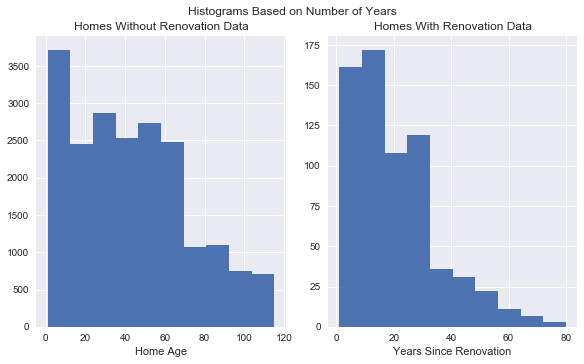

In [26]:
# Creating a histogram to show the frequency of homes at various ages for homes
# without renovation data, and a histogram to show the frequency of homes
# with some number of years since their renovation if they have renovation data
q2f1_1, axes = plt.subplots(1, 2, figsize=(8,5), constrained_layout=True)

q2ax1_0 = age_col.hist(ax=axes[0])
q2ax1_1 = since_reno_col.hist(ax=axes[1])

q2ax1_0.title.set_text("Homes Without Renovation Data")
q2ax1_1.title.set_text("Homes With Renovation Data")

q2ax1_0.set_xlabel("Home Age")
q2ax1_1.set_xlabel("Years Since Renovation")

q2f1_1.suptitle("Histograms Based on Number of Years")
plt.show()

In [27]:
# Creating variables to log the number of years (either home age or years since
# renovation) in order to make the data more normally distributed
age_log = np.log(age_col)
since_reno_log = np.log(since_reno_col)

In [28]:
# Creating new columns in the appropriate dataframes for the log data
without_reno_df["home_age_log"] = age_log
with_reno_df["since_reno_log"] = since_reno_log

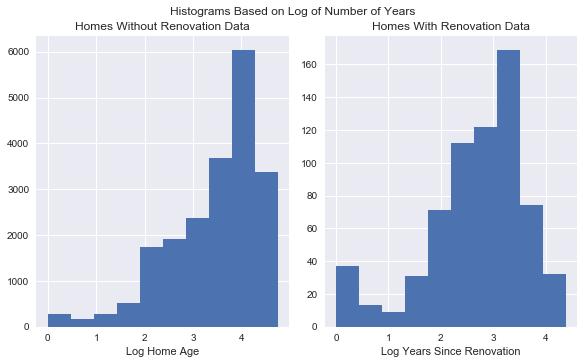

In [29]:
# Creating histograms to show the more normal distributions for the log data
q2f1_2, axes = plt.subplots(1, 2, figsize=(8,5), constrained_layout=True)

q2ax1_2_0 = age_log.hist(ax=axes[0])
q2ax1_2_1 = since_reno_log.hist(ax=axes[1])

q2ax1_2_0.title.set_text("Homes Without Renovation Data")
q2ax1_2_1.title.set_text("Homes With Renovation Data")

q2ax1_2_0.set_xlabel("Log Home Age")
q2ax1_2_1.set_xlabel("Log Years Since Renovation")

q2f1_2.suptitle("Histograms Based on Log of Number of Years")

plt.show()

#### Question 2 Modeling

In [30]:
# Summary of the ordinary least squares reqression comparing price with the log 
# age of homes that do not have renovation data
model_without_reno = ols(formula=('price~home_age_log'), data=without_reno_df).fit()
model_without_reno.rsquared

0.012978124843974426

In [31]:
# Summary of the ordinary least squares reqression comparing price with the log 
# number of years since a home has been renovated for homes with renovation data
model_with_reno = ols(formula=('price~since_reno_log'), data=with_reno_df).fit()
model_with_reno.rsquared

0.006171331892929843

#### Question 2 Summary

Unfortunately, there is a chance that the number of years since a home was renovated is statistically insignificant, as shown by the P-Value of .042 (which is close to the popular .05 threshold for significance). We learned that there is little impact on price based on when a home was renovated and it does not act exactly the same as home age.

## Question 3: Does paying more for a house get you more quantity (bedrooms, bathrooms) or quality (condition, grade)?

In [32]:
# Creating a new dataframe with only these seven columns
q3_df = df.filter(["price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "condition", "grade"])

# Adding a new variable for total square footage
q3_df["total_sqft"] = q3_df["sqft_living"] + q3_df["sqft_lot"]

# Dropping other SqFt columns
q3_df = q3_df.drop(columns=["sqft_living", "sqft_lot"])

In [33]:
# Creating variables for each column
price = q3_df["price"]
bedrooms = q3_df["bedrooms"]
bathrooms = q3_df["bathrooms"]
condition = q3_df["condition"]
grade = q3_df["grade"]
total_sqft = q3_df["total_sqft"]

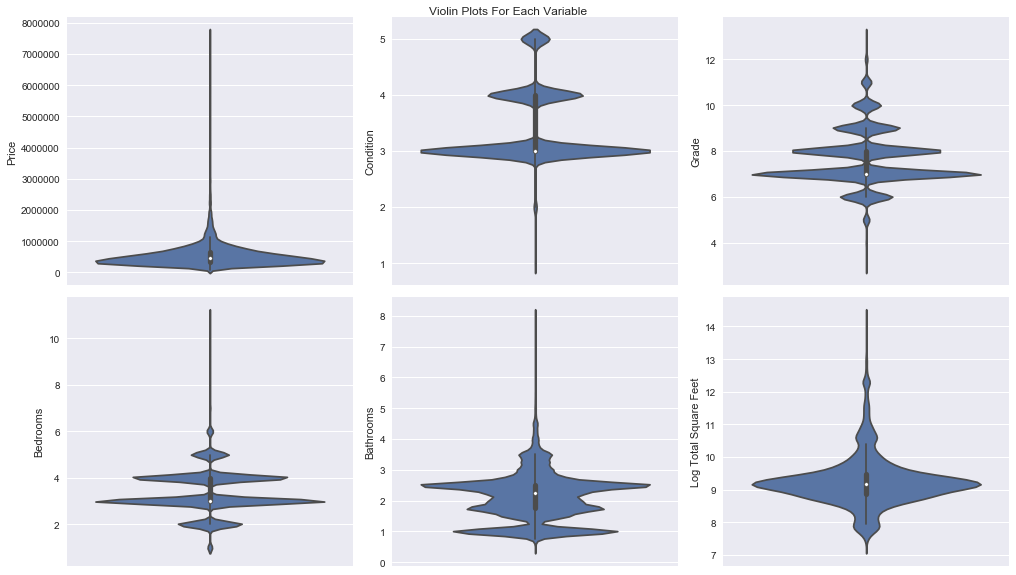

In [34]:
# Creating violinplots (oooh) for each variable
q3f1, axes = plt.subplots(2, 3, figsize=(14,8), constrained_layout=True)

q3ax1_0_0 = sns.violinplot(price, orient='v', ax=axes[0,0])
q3ax1_0_1 = sns.violinplot(condition, orient='v', ax=axes[0,1])
q3ax1_0_2 = sns.violinplot(grade, orient='v', ax=axes[0,2])
q3ax1_1_0 = sns.violinplot(bedrooms, orient='v', ax=axes[1,0])
q3ax1_1_1 = sns.violinplot(bathrooms, orient='v', ax=axes[1,1])
q3ax1_1_2 = sns.violinplot(total_sqft_log, orient='v', ax=axes[1,2])

q3ax1_0_0.set_ylabel("Price")
q3ax1_0_1.set_ylabel("Condition")
q3ax1_0_2.set_ylabel("Grade")
q3ax1_1_0.set_ylabel("Bedrooms")
q3ax1_1_1.set_ylabel("Bathrooms")
q3ax1_1_2.set_ylabel("Log Total Square Feet")

q3f1.suptitle("Violin Plots For Each Variable")

plt.show()

#### Splitting data frame into four equal parts, based on quartiles

In [35]:
# Sorting and q-cutting in order to arrive at ranges for quartiles
q3_df = q3_df.sort_values(by="price")
pd.qcut(q3_df["price"], 4).value_counts()

(322000.0, 450000.0]     5445
(77999.999, 322000.0]    5406
(450000.0, 645000.0]     5374
(645000.0, 7700000.0]    5371
Name: price, dtype: int64

In [36]:
# Creating a new Quartile column
q3_df.loc[q3_df["price"] <= 323000, "quartile"] = 1
q3_df.loc[q3_df["price"].between(322000.1, 450000.0, inclusive=True), "quartile"] = 2
q3_df.loc[q3_df["price"].between(450000.1, 645000.0, inclusive=True), "quartile"] = 3
q3_df.loc[q3_df["price"] > 645000, "quartile"] = 4

In [50]:
# Standardizing all variables to the same scale
scaled_df = pd.DataFrame()
scaled_df["price"] = q3_df["price"]
scaled_df["quartile"] = q3_df["quartile"]
scaled_df["bedrooms"] = (bedrooms-min(bedrooms))/(max(bedrooms)-min(bedrooms))
scaled_df["bathrooms"] = (bathrooms-min(bathrooms))/(max(bathrooms)-min(bathrooms))
scaled_df["total_sqft"] = (total_sqft-min(total_sqft))/(max(total_sqft)-min(total_sqft))
scaled_df["condition"] = (condition-min(condition))/(max(condition)-min(condition))
scaled_df["grade"] = (grade-min(grade))/(max(grade)-min(grade))

In [51]:
melted_q3_df = pd.melt(scaled_df,
                       id_vars=["price", "quartile"],
                       var_name="all_var")
melted_q3_df.head()

price  quartile   all_var  value
0  78000.0       1.0  bedrooms    0.1
1  80000.0       1.0  bedrooms    0.0
2  81000.0       1.0  bedrooms    0.1
3  82000.0       1.0  bedrooms    0.2
4  82500.0       1.0  bedrooms    0.1

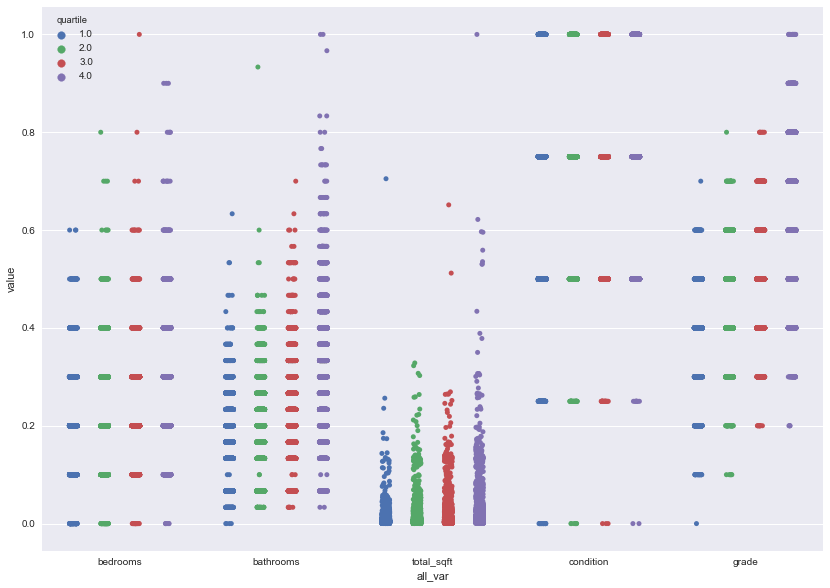

In [56]:
plt.figure(figsize=(14,10))

sns.stripplot(x="all_var",
              y="value",
              hue="quartile",
              data=melted_q3_df,
              dodge=True)

plt.show()

# Our Model

In [37]:
# Reminding ourselves how many k-clusters and k-folds we're working with

print(KLUSTERS)
print(KFOLDS)

15
4


In [38]:
# Clustering the data based on latitude and longitude, and creating a new
# column, K Cluster ID, to identify the cluster within the dataframe

kmeans = KMeans(algorithm="elkan", n_clusters=KLUSTERS).fit(df[["lat", "long"]])
df["kcluster_id"] = kmeans.labels_

In [39]:
# Creating a central point within each cluster to visualize
centroids = kmeans.cluster_centers_

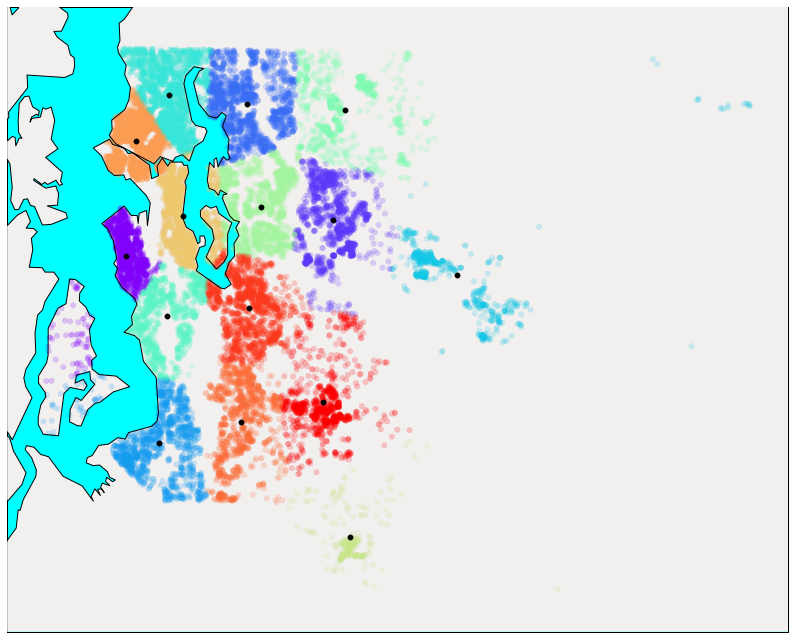

In [40]:
# Visualizing the clusters
plt.figure(figsize=(14,14))
m = Basemap(
    projection='lcc',
    resolution="h",
    lat_0=(max(df["lat"])+min(df["lat"]))/2,
    lon_0=(max(df["long"])+min(df["long"]))/2,
    width= 100000,
    height= 80000,
)

# Plotting each home as a dot, colored by cluster
m.drawmapboundary(fill_color='aqua', zorder=-2)
m.fillcontinents(color='#f2efef',lake_color='#b3efee', zorder=-1)
m.drawcoastlines()
m.scatter(
    df["long"].values,
    df["lat"].values,
    latlon=True,
    c= kmeans.labels_.astype(float),
    s=30,
    cmap="rainbow",
    alpha=.2,
)

# Plotting central points
m.scatter(
    centroids[:, 1],
    centroids[:, 0],
    latlon=True,
    c= "black",
    s=30,
)

plt.show()

In [41]:
# K-Folding each cluster
kclusters = df.groupby("kcluster_id")
k_clusters_tt_splits = []
for i in range(len(kclusters)):
    tt_splits = k_fold_tt_splits(
        KFOLDS,
        kclusters.get_group(i),
    )
    k_clusters_tt_splits.append(tt_splits)

In [42]:
# Finding the best model, based on mean squared error, for each cluster
def find_best_model_mse(tt_splits, indep, cols):
    modeling_params = indep+"~"+"+".join(cols)
    best_model = None
    lowest_mse = maxsize
    associated_tt_split = None
    for data in tt_splits:
        if data[0].shape[0] == 0:
            continue
        model = ols(formula= modeling_params, data=data[0]).fit()
        preds = model.predict(data[1])
        model_mse = rmse_(data[1]["price"], preds)
        if model_mse is None:
            continue
        if model_mse < lowest_mse and model.rsquared > 0:
            lowest_mse = model_mse
            best_model = model
            associated_tt_split = data
    return best_model, lowest_mse, associated_tt_split

In [48]:
# Creating a list of the best models
best_models = []

for k_cluster_tt_splits in k_clusters_tt_splits:
    best_model, rmse, associated_tt_split = find_best_model_mse(k_cluster_tt_splits, 
                                                                "price", 
                                                                ["sqft_living", "grade"])
    if best_model is None:
        continue
    k_ids = list(associated_tt_split[0]["kcluster_id"])
    print("K-Cluster ID:", k_ids[0]+1, "\n\t"+
          "Root Mean Squared Error: ", rmse, "\n\t"+ 
          "R-Squared:", best_model.rsquared, "\n")
    best_models.append(best_model)

K-Cluster ID: 1 
	Root Mean Squared Error:  146370.99422709117 
	R-Squared: 0.5737450608433619 

K-Cluster ID: 2 
	Root Mean Squared Error:  131750.3282594155 
	R-Squared: 0.48562754718093426 

K-Cluster ID: 3 
	Root Mean Squared Error:  265214.46816618973 
	R-Squared: 0.6363870092857788 

K-Cluster ID: 4 
	Root Mean Squared Error:  77185.50341871638 
	R-Squared: 0.23699012500599048 

K-Cluster ID: 5 
	Root Mean Squared Error:  41874.004543777286 
	R-Squared: 0.781944600003 

K-Cluster ID: 6 
	Root Mean Squared Error:  182079.4227198121 
	R-Squared: 0.5502074774218997 

K-Cluster ID: 7 
	Root Mean Squared Error:  137380.80326135078 
	R-Squared: 0.7303589100566799 

K-Cluster ID: 8 
	Root Mean Squared Error:  102939.60546698752 
	R-Squared: 0.862418849399976 

K-Cluster ID: 9 
	Root Mean Squared Error:  349966.8268866082 
	R-Squared: 0.6398726998894959 

K-Cluster ID: 11 
	Root Mean Squared Error:  242805.72603660505 
	R-Squared: 0.7434800767139431 

K-Cluster ID: 12 
	Root Mean Squared

Our thought process - refine a model based on location. 

We created k-clusters, which cluster our data based on lat/long location, and then tried to predict price based on the square footage and grade of the house. We arrived at square footage (sqft_living) and grade as our main independent variables based on our earlier exploratory data analyis (Question 1) - these two variables had the highest R-Squared values before looking at location.

We tried clustering in many different ways, from 10 clusters to 80, and arrived at 15 clusters as the number we would model with. 15 clusters provided enough data to train and test our models while being specific enough to see variation in our models between clusters. Some clusters are able to predict price better than others! 